### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preparation

In [3]:
#(NT,nt)   A - 0
#(NT,rp)   B - 1
#(NT,rt)   C - 2
#(NT,tw)   D - 3

#(RP,nt)   E - 4
#(RP,rp)   F - 5
#(RP,rt)   G - 6
#(RP,tw)   H - 7
   
#(RT,nt)   I - 8
#(RT,rp)   J - 9
#(RT,rt)   K - 10
#(RT,tw)   L - 11

def reconstruct_traj(row):
    f_i=row
    f_i=f_i[1:]
    f_i = f_i[:-1]
    s=str(f_i)
    s=s.replace(" ", "")
    x = s.split("[")

    t=[]
    for i in range(0,len(x)):
        r=x[i].replace("]", "").split(",")
        if len(r) >=2:
            t.append([r[0],r[1]])
    
    return t

def remove_action(traj):   ##keep only the S_A pair
    seq=[]
    #print(traj)
    for i in range(len(traj)):
        seq.append(int(traj[i][0]))
    return seq

users_traj = pd.read_csv("/content/drive/MyDrive/Trajectories+code/users_all_trajectories.csv") 
trolls_traj=pd.read_csv("/content/drive/MyDrive/Trajectories+code/trolls_all_trajectories.csv")

users_traj['state_sequence'] = users_traj.apply(lambda row : reconstruct_traj(row['state_sequence']), axis = 1)
trolls_traj['state_sequence'] = trolls_traj.apply(lambda row : reconstruct_traj(row['state_sequence']), axis = 1)

users_traj['sequence_numbers'] = users_traj.apply(lambda row : remove_action(row['state_sequence']), axis = 1)
trolls_traj['sequence_numbers'] = trolls_traj.apply(lambda row : remove_action(row['state_sequence']), axis = 1)

users_traj['label'] = 0
trolls_traj['label']= 1

frames = [users_traj, trolls_traj]
data = pd.concat(frames)
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
len(data)

2322

In [5]:
# Train - Test Split over all users/trolls
data_train, data_test = train_test_split(data, test_size=0.15, random_state=42)

In [6]:
len(data_test[data_test['label'] == 1])

53

### Trajectory Formation


In [6]:
#preparing the splitted sequences of trainig users/trolls
users = data_train[data_train['label']==0].reset_index(drop=True)
trolls = data_train[data_train['label']==1].reset_index(drop=True)
max_length = 200 #trajectory Length: L. LSTM input
new_data = pd.DataFrame(columns=['sequence_numbers','label'])
count=0
#users
#iterating over users from training set
for i in range(len(users)):
  user = users.loc[i]
  traj = users.loc[i]['sequence_numbers']
  l = len(traj)

  if l <= max_length: #if trajectory length less then max_lenght add it as it is
    res=traj
    new_data.loc[count]=[res,0] # label 0 for users
    count=count+1

  else:  #else split it into records
    res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
    for j in range(len(res)):
      new_data.loc[count]=[res[j].tolist(),0] # label 0 for users
      count=count+1
      
new_data_trolls=pd.DataFrame(columns=['sequence_numbers','label'])

count=0
#trolls
#iterating over trolls from training set
for i in range(len(trolls)):
  troll=trolls.loc[i]
  traj = trolls.loc[i]['sequence_numbers']
  l = len(traj)

  if l <= max_length:  #if trajectory length less then max_lenght add it as it is
    res=traj
    new_data_trolls.loc[count]=[res,1]
    count=count+1

  else: #else split it into records
    res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
    for j in range(len(res)):
      new_data_trolls.loc[count]=[res[j].tolist(),1]
      count=count+1

#all_data is the dataframe that contains the extracted sequences of users and trolls from train set
frames = [new_data, new_data_trolls]
all_train_data = pd.concat(frames)
all_train_data = all_train_data.sample(frac=1).reset_index(drop=True)

In [7]:
print (" After Splitting Training Set  --> Users : " + str(len(new_data)) +" Trolls : " +str(len(new_data_trolls)))

 After Splitting Training Set  --> Users : 21663 Trolls : 12796


In [8]:
# same for test set extracting the trajectories
#preparing the splitted sequences
users = data_test[data_test['label']==0].reset_index(drop=True)
trolls = data_test[data_test['label']==1].reset_index(drop=True)
max_length = 200 #trajectory Length: L. LSTM input
new_data = pd.DataFrame(columns=['sequence_numbers','label'])
count=0
#users
for i in range(len(users)):
  user = users.loc[i]
  traj = users.loc[i]['sequence_numbers']
  l = len(traj)

  if l <= max_length: #if trajectory length less then max_lenght add it as it is
    res=traj
    new_data.loc[count]=[res,0]
    count=count+1

  else:  #else split it into records
    res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
    for j in range(len(res)):
      new_data.loc[count]=[res[j].tolist(),0]
      count=count+1
      
new_data_trolls=pd.DataFrame(columns=['sequence_numbers','label'])

count=0
#trolls
#iterating over trolls
for i in range(len(trolls)):
  troll=trolls.loc[i]
  traj = trolls.loc[i]['sequence_numbers']
  l = len(traj)

  if l <= max_length:  #if trajectory length less then max_lenght add it as it is
    res=traj
    new_data_trolls.loc[count]=[res,1]
    count=count+1

  else: #else split it into records
    res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
    for j in range(len(res)):
      new_data_trolls.loc[count]=[res[j].tolist(),1]
      count=count+1

#all_data is the dataframe that contains the extracted sequences
frames = [new_data, new_data_trolls]
all_test_data = pd.concat(frames)
all_test_data = all_test_data.sample(frac=1).reset_index(drop=True)

In [9]:
print (" After Splitting Test Set--> Users : " + str(len(new_data)) +" Trolls : " +str(len(new_data_trolls)))

 After Splitting Test Set--> Users : 3636 Trolls : 3434


### Trajectory Classification
Training with 85% train and 15% test

In [10]:
Xx=all_train_data['sequence_numbers'].values  #trajectories
Y=all_train_data['label'].values

max_length = 200
X = pad_sequences(Xx, maxlen=max_length, padding='post')  ## fill 0s
# Split data into 85% training & 15% test
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.15, random_state=42)

print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_validation=x_validation.reshape(x_validation.shape[0],x_validation.shape[1],1)

print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

x_train=np.asarray(x_train).astype(np.int)
y_train=np.asarray(y_train).astype(np.int)

x_validation=np.asarray(x_validation).astype(np.int)
y_validation=np.asarray(y_validation).astype(np.int)


# build the neural network
model = Sequential()
model.add(LSTM(100, return_sequences = True, input_shape = (x_train.shape[1],1 )))
model.add(Dropout(rate = 0.2))
model.add(LSTM(75,return_sequences = True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(75,return_sequences = True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(50))
model.add(Dropout(rate = 0.2))
model.add(Dense(1, activation = 'sigmoid'))
es = EarlyStopping(monitor='auc', mode='max', patience=10, verbose=1) ## patience can be varied
model.compile(optimizer = "adam", loss = "binary_crossentropy",metrics=["acc","AUC","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","Precision","Recall"])
history = model.fit(x = x_train, y = y_train,callbacks=[es], validation_data=(x_validation, y_validation), batch_size = 100, epochs = 100)

(29290, 200) (29290,)
(5169, 200) (5169,)
(29290, 200, 1) (29290,)
(5169, 200, 1) (5169,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

Epoch 1/100
293/293 [==============================] - 25s 47ms/step - loss: 0.2253 - acc: 0.9245 - auc: 0.9574 - false_negatives: 812.0000 - false_positives: 1400.0000 - true_negatives: 17050.0000 - true_positives: 10028.0000 - precision: 0.8775 - recall: 0.9251 - val_loss: 0.1943 - val_acc: 0.9334 - val_auc: 0.9707 - val_false_negatives: 131.0000 - val_false_positives: 213.0000 - val_true_negatives: 3000.0000 - val_true_positives: 1825.0000 - val_precision: 0.8955 - val_recall: 0.9330
Epoch 2/100
293/293 [==============================] - 12s 39ms/step - loss: 0.2062 - acc: 0.9250 - auc: 0.9659 - false_negatives: 995.0000 - false_positives: 1201.0000 - true_negatives: 17249.0000 - true_positives: 9845.0000 - precision: 0.8913 - recall: 0.9082 - val_loss: 0.2166 - val_acc: 0.9317 - val_auc: 0.9477 - val_false_negatives: 57.0000 - val_false_positives: 296.0000 - val_true_negatives: 2917.0000 - val_true_positives: 1899.0000 - val_precision: 0.8651 - val_recall: 0.9709
Epoch 3/100
293/29

In [11]:
x_test = all_test_data['sequence_numbers'].values  #trajectories
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')  ## fill 0s
y_test = all_test_data['label'].values

x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_test=np.asarray(y_test).astype(np.int)

results = model.evaluate(x_test, y_test, batch_size=100)  #model evaluation on the test set
print(results)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


71/71 [==============================] - 4s 23ms/step - loss: 0.0475 - acc: 0.9866 - auc: 0.9966 - false_negatives: 33.0000 - false_positives: 62.0000 - true_negatives: 3574.0000 - true_positives: 3401.0000 - precision: 0.9821 - recall: 0.9904
[0.047525350004434586, 0.986562967300415, 0.996616005897522, 33.0, 62.0, 3574.0, 3401.0, 0.9820964336395264, 0.9903902411460876]


### Stratified Cross validation

In [ ]:
X=data_train['sequence_numbers'].values
y=data_train['label'].values

y=np.asarray(y).astype(np.int)
max_length = 200
#X = pad_sequences(Xx, maxlen=max_length, padding='post')

#metrics
Acc =[]
Pre =[]
Rec = []
Auc = []
F1 =[]
FI =[]
TPR = []
TNR = []
Loss=[]

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):

    # Generate batches from indices
    x_train, x_test = X[train_indices], X[val_indices]
    y_train, y_test = y[train_indices], y[val_indices]

    x_train_df = pd.DataFrame(columns = ['sequence_numbers', 'label'])
    for j in range(len(x_train)):
      x_train_df.loc[j] = [x_train[j], y_train[j]]

    x_test_df = pd.DataFrame(columns = ['sequence_numbers', 'label'])
    for j in range(len(x_test)):
      x_test_df.loc[j] =  [x_test[j], y_test[j]]

    #preparing the splitted sequences of trainig users/trolls
    users = x_train_df[x_train_df['label']==0].reset_index(drop=True)
    trolls = x_train_df[x_train_df['label']==1].reset_index(drop=True)
    max_length = 200 #trajectory Length: L. LSTM input
    new_data = pd.DataFrame(columns=['sequence_numbers','label'])
    count=0
    #users
    #iterating over users from training set
    for i in range(len(users)):
      user = users.loc[i]
      traj = users.loc[i]['sequence_numbers']
      l = len(traj)

      if l <= max_length: #if trajectory length less then max_lenght add it as it is
        res=traj
        new_data.loc[count]=[res,0] # label 0 for users
        count=count+1

      else:  #else split it into records
        res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
        for j in range(len(res)):
          new_data.loc[count]=[res[j].tolist(),0] # label 0 for users
          count=count+1
          
    new_data_trolls=pd.DataFrame(columns=['sequence_numbers','label'])

    count=0
    #trolls
    #iterating over trolls from training set
    for i in range(len(trolls)):
      troll=trolls.loc[i]
      traj = trolls.loc[i]['sequence_numbers']
      l = len(traj)

      if l <= max_length:  #if trajectory length less then max_lenght add it as it is
        res=traj
        new_data_trolls.loc[count]=[res,1]
        count=count+1

      else: #else split it into records
        res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
        for j in range(len(res)):
          new_data_trolls.loc[count]=[res[j].tolist(),1]
          count=count+1

    #all_data is the dataframe that contains the extracted sequences of users and trolls from train set
    frames = [new_data, new_data_trolls]
    all_train_data_skf = pd.concat(frames)
    all_train_data_skf = all_train_data_skf.sample(frac=1).reset_index(drop=True)

    #preparing the splitted sequences of test users/trolls
    users = x_test_df[x_test_df['label']==0].reset_index(drop=True)
    trolls = x_test_df[x_test_df['label']==1].reset_index(drop=True)
    max_length = 200 #trajectory Length: L. LSTM input
    new_data = pd.DataFrame(columns=['sequence_numbers','label'])
    count=0
    #users
    #iterating over users from training set
    for i in range(len(users)):
      user = users.loc[i]
      traj = users.loc[i]['sequence_numbers']
      l = len(traj)

      if l <= max_length: #if trajectory length less then max_lenght add it as it is
        res=traj
        new_data.loc[count]=[res,0] # label 0 for users
        count=count+1

      else:  #else split it into records
        res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
        for j in range(len(res)):
          new_data.loc[count]=[res[j].tolist(),0] # label 0 for users
          count=count+1
          
    new_data_trolls=pd.DataFrame(columns=['sequence_numbers','label'])

    count=0
    #trolls
    #iterating over trolls from training set
    for i in range(len(trolls)):
      troll=trolls.loc[i]
      traj = trolls.loc[i]['sequence_numbers']
      l = len(traj)

      if l <= max_length:  #if trajectory length less then max_lenght add it as it is
        res=traj
        new_data_trolls.loc[count]=[res,1]
        count=count+1

      else: #else split it into records
        res = np.array_split(traj[0:(len(traj)-len(traj)%max_length)],len(traj)/max_length)
        for j in range(len(res)):
          new_data_trolls.loc[count]=[res[j].tolist(),1]
          count=count+1

    #all_data is the dataframe that contains the extracted sequences of users and trolls from train set
    frames = [new_data, new_data_trolls]
    all_test_data_skf = pd.concat(frames)
    all_test_data_skf = all_train_data_skf.sample(frac=1).reset_index(drop=True)


    x_train = all_train_data_skf['sequence_numbers'].values
    x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
    y_train = all_train_data_skf['label'].values

    x_test = all_test_data_skf['sequence_numbers'].values
    x_test = pad_sequences(x_test, maxlen=max_length, padding='post')
    y_test = all_test_data_skf['label'].values


    x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

    x_train=np.asarray(x_train).astype(np.int)
    y_train=np.asarray(y_train).astype(np.int)

    x_test=np.asarray(x_test).astype(np.int)
    y_test=np.asarray(y_test).astype(np.int)


    
    # build the neural network
    model = Sequential()
    model.add(LSTM(100, return_sequences = True, input_shape = (x_train.shape[1],1 )))
    model.add(Dropout(rate = 0.2))
    model.add(LSTM(75,return_sequences = True))
    model.add(Dropout(rate = 0.2))
    model.add(LSTM(75,return_sequences = True))
    model.add(Dropout(rate = 0.2))
    model.add(LSTM(50))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    #es = EarlyStopping(monitor='auc', mode='max', patience=20, verbose=1)
    model.compile(optimizer = "adam", loss = "binary_crossentropy",metrics=["acc","AUC","FalseNegatives","FalsePositives","TrueNegatives","TruePositives","Precision","Recall"])
    model.fit(x = x_train, y = y_train, batch_size = 64,verbose=1, epochs = 30)
    history = model.evaluate(x_test, y_test, batch_size=100)
    Loss.append(history[0])

    acc= history[1]
    Acc.append(acc)

    auc = history[2]
    Auc.append(auc)

    fn= history[3]
    fp = history[4]
    tn = history[5]
    tp = history[6]


    tpr = tp/float(tp+fn)
    tnr = tn/float(tn+fp)

    TPR.append(tpr)
    TNR.append(tnr)

    prec= history[7]
    Pre.append(prec)

    rec = history[8]
    Rec.append(rec)
    try:
      f1 = 2 * ((prec*rec)/(prec+rec))
    except ZeroDivisionError:
      f1 = 0
    F1.append(f1)

print("LSTM With Trajectory classification")
print("accuracy",np.mean(Acc),np.std(Acc))
print("precision",np.mean(Pre),np.std(Pre))
print("recall",np.mean(Rec),np.std(Rec))
print("f1",np.mean(F1),np.std(F1))
print("AUC",np.mean(Auc),np.std(Auc))
print("TPR",np.mean(TPR),np.std(TPR))
print("TNR",np.mean(TNR),np.std(TNR))

### Troll Score Computation and CDF plot

In [12]:
#### sliding window validation

### troll score classification:  e.g: input [0, 0, 0, 0, 0], mask [1, 1, 1, 1, 1] => troll score is the number of matched 1's

max_length=200

output=pd.DataFrame(columns=['screen_name','sequence_numbers','label','troll_score'])

counter=0
users_acc=[]
trolls_acc=[]

users = data_test[data_test['label']==0].reset_index(drop=True)
trolls = data_test[data_test['label']==1].reset_index(drop=True)

#computing the troll score for the users
#sliding window
#compute the ratio of how many time the sequences classified as troll

for i in range(len(users)):
  user=users.loc[i]
  traj = users.loc[i]['sequence_numbers']
  l = len(traj)

  if l <= max_length:  # data used in the training will be ignored
    res=traj   #then do nothing

  else:
    res=[]
    for j in range(l-max_length -1):
      #if j%max_length ==0:     #data used in the training will be ignored
      #  continue
      res.append(traj[j:j+max_length])

    if len(res) > 0:
      x_test = pad_sequences(res, maxlen=max_length, padding='post')
      x_test= x_test.reshape(x_test.shape[0],x_test.shape[1],1)
      y_test=np.asarray([1]*len(x_test)).astype(np.int)  
      history = model.evaluate(x_test, y_test, batch_size=100)
      output.loc[counter]=[user['screen_name'],user['sequence_numbers'],0,history[1]]
      counter = counter+1
      users_acc.append(history[1])

#computing the troll score for the trolls
#sliding window
#compute the ratio of how many time the sequences classified as troll
counter =0
for i in range(len(trolls)):
  troll=trolls.loc[i]
  traj = trolls.loc[i]['sequence_numbers']
  l = len(traj)

  if l <= max_length:  
    res=traj   #do nothing because data used in the training

  else:
    res=[]
    for j in range(l- max_length -1):
      #if j%max_length == 0:     #data used in the training will be ignored
      #  continue
      res.append(traj[j:j+max_length])
    if len(res) > 0:
      x_test = pad_sequences(res, maxlen=max_length, padding='post')
      x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
      y_test=np.asarray([1]*len(x_test)).astype(np.int)
      history = model.evaluate(x_test, y_test, batch_size=100)
      output.loc[counter]=[user['screen_name'],user['sequence_numbers'],1,history[1]]
      counter=counter+1
      trolls_acc.append(history[1])

 3/23 [==>...........................] - ETA: 0s - loss: 6.9819 - acc: 0.0000e+00 - auc: 0.0000e+00 - false_negatives: 300.0000 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1/1 [==============================] - 0s 35ms/step - loss: 0.1299 - acc: 0.9388 - auc: 0.0000e+00 - false_negatives: 3.0000 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 46.0000 - precision: 1.0000 - recall: 0.9388


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


217/217 [==============================] - 4s 17ms/step - loss: 0.0028 - acc: 1.0000 - auc: 0.0000e+00 - false_negatives: 0.0000e+00 - false_positives: 0.0000e+00 - true_negatives: 0.0000e+00 - true_positives: 21615.0000 - precision: 1.0000 - recall: 1.0000


Cumulative distribution function

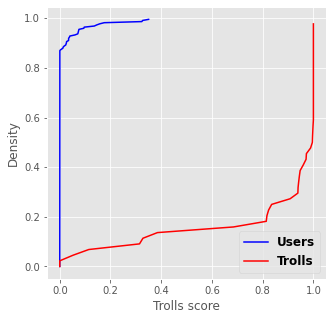

In [13]:
# defining the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.style.use('ggplot')
plt.rcParams['figure.figsize'] = (5, 5)

# normal distribution
# sort the data in ascending order
# get the cdf values of y
# No of data points used
N = len(users_acc)
x = np.sort(users_acc)
y = np.arange(N) / float(N)
plt.plot(x, y,color='blue',label='Users')

df=pd.DataFrame(columns=['x','y'])
df['x']=x
df['y']=y

df.to_csv("/content/drive/My Drive/D/NEW 30-4-2022/CDF/users_cdf_200.csv")


N = len(trolls_acc)
x = np.sort(trolls_acc)
y = np.arange(N) / float(N)


df=pd.DataFrame(columns=['x','y'])
df['x']=x
df['y']=y

df.to_csv("/content/drive/My Drive/D/NEW 30-4-2022/CDF/trolls_cdf_200.csv")
plt.plot(x, y,color='red',label='Trolls')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

mpl.rc('font', **font)
  
# plotting
plt.xlabel('Trolls score')
plt.ylabel('Density')
plt.legend()

In [15]:
mydf = pd.DataFrame(columns=['score', 'label'])

co = 0
for i in range(len(trolls_acc)):
  mydf.loc[co] = [trolls_acc[i], 1]
  co = co + 1

for i in range(len(users_acc)):
  mydf.loc[co] = [users_acc[i],0]
  co = co + 1

mydf.to_csv("scores.csv")